In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict, load_from_disk
from tqdm.auto import tqdm
from nltk import sent_tokenize
from more_itertools import windowed
from random import choice, seed
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
tqdm.pandas()

In [532]:
corpus = pd.read_csv("../data/rom_real_dataset_final.csv")
corpus = corpus[["author", "title", "epoch", "text", "pub_year_estim"]]

In [530]:
corpus["text"] = corpus.text.str.replace("[»›]", '"', regex=True)
corpus["text"] = corpus.text.str.replace("[«‹]", '"', regex=True)
corpus["text"] = corpus.text.str.replace("–", '-', regex=True)
corpus.text.str.contains("[»›]").any(), corpus.text.str.contains("[«‹]").any(), corpus.text.str.contains("–").any()

(False, False, False)

In [5]:
corpus_train = pd.concat([
    corpus.query("epoch == 'romantik'").sample(15, random_state=42),
    corpus.query("epoch == 'realismus'").sample(15, random_state=42)
])
corpus_test = corpus.drop(corpus_train.index)

with open("../data/nsp_corpus_train_idx.txt", "w") as f:
    f.write("\n".join(map(str, corpus_train.index)))

with open("../data/nsp_corpus_test_idx.txt", "w") as f:
    f.write("\n".join(map(str, corpus_test.index)))

In [6]:
def make_nsp_dataset(df, random_state=42):
    seed(random_state)
    data = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Creating NSP dataset"):
        text = row.pop("text")
        sents = sent_tokenize(text, language="german")
        sent_idc = list(range(len(sents)))
        for index, pair in enumerate(windowed(sents, 2)):
            sent_1_idx, sent_2_idx = index, index + 1
            sent_1, sent_2 = pair 
            
            true_pair = " ".join(pair)
            true_entry = row.copy()
            true_entry["pair"] = true_pair
            true_entry["sent1_idx"] = sent_1_idx
            true_entry["sent2_idx"] = sent_2_idx
            true_entry["sent1"] = sent_1
            true_entry["sent2"] = sent_2
            true_entry["label"] = 0
            data.append(true_entry)
            
            # chose any sent from same text that is not sent_2
            while True:
                false_sent_idx = choice(sent_idc)
                false_sent = sents[false_sent_idx]
                if sent_2 != false_sent:
                    break
            
            false_pair = " ".join((sent_1, false_sent))
            false_entry = row.copy()
            false_entry["pair"] = false_pair
            false_entry["sent1_idx"] = sent_1_idx
            false_entry["sent2_idx"] = false_sent_idx
            false_entry["sent1"] = sent_1
            false_entry["sent2"] = false_sent
            false_entry["label"] = 1
            data.append(false_entry)

    return pd.DataFrame.from_records(data)    

In [7]:
train_dataset = make_nsp_dataset(corpus_train)
test_dataset = make_nsp_dataset(corpus_test)

Creating NSP dataset:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_dataset.label.value_counts()

In [ ]:
test_dataset.label.value_counts()

In [ ]:
hf_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_dataset),
    "test": Dataset.from_pandas(test_dataset)
})

hf_dataset.save_to_disk("../data/rom_rea_nsp_hf_dataset")

In [ ]:
hf_dataset = load_from_disk("../data/rom_rea_nsp_hf_dataset")
hf_dataset

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_metric

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-nsp", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

In [ ]:
hf_dataset = hf_dataset.map(
    lambda entry: tokenizer(entry["pair"], padding="max_length", truncation=True),
    batched=True,
    num_proc=12
)

In [ ]:
hf_dataset = hf_dataset.rename_column("label", "labels")
hf_dataset.set_format("torch")

In [ ]:

training_args = TrainingArguments(
    num_train_epochs=3,
    output_dir="so_classif",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=48,
    learning_rate=3e-5,
    logging_dir="so_classif/logs",
    logging_strategy="steps",
    logging_steps=10,
    logging_first_step=True,
    evaluation_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=5000,
    save_total_limit=5,
    overwrite_output_dir=True,
    warmup_steps=350,
)

In [ ]:
import numpy as np
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
hf_train_dataset = hf_dataset["train"]
hf_train_dataset = hf_train_dataset.train_test_split(train_size=0.98)
hf_train_dataset

In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=hf_train_dataset["train"],
    eval_dataset=hf_train_dataset["test"],
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
predictions = trainer.predict(hf_dataset["test"])

In [ ]:
model.save_pretrained("bert-nsp")
tokenizer.save_pretrained("bert-nsp")

In [ ]:
model = model.to("cpu")
torch.cuda.empty_cache()

In [ ]:
test_dataset = hf_dataset["test"].to_pandas()
test_dataset

In [ ]:
test_dataset["pred"] = predictions.predictions.argmax(axis=1)

In [ ]:
test_dataset["match"] = (test_dataset["labels"] == test_dataset["pred"]).astype("int")

In [ ]:
test_dataset = test_dataset.drop(columns=["input_ids", "token_type_ids", "attention_mask"])

In [ ]:
test_dataset.to_csv("../data/testdataset_bert.csv", index=False)

In [ ]:
##################################################################################

In [645]:
test_dataset = pd.read_csv("../data/testdataset_bert.csv")
test_dataset.shape

(349100, 11)

In [646]:
from sklearn.metrics import classification_report

print(classification_report(test_dataset["labels"], test_dataset["pred"]))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78    174550
           1       0.80      0.72      0.76    174550

    accuracy                           0.77    349100
   macro avg       0.77      0.77      0.77    349100
weighted avg       0.77      0.77      0.77    349100



In [647]:
from sklearn.metrics import classification_report

print(classification_report(test_dataset.query("epoch == 'romantik'")["labels"], test_dataset.query("epoch == 'romantik'")["pred"]))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     77563
           1       0.81      0.70      0.75     77563

    accuracy                           0.77    155126
   macro avg       0.78      0.77      0.77    155126
weighted avg       0.78      0.77      0.77    155126



In [648]:
print(classification_report(test_dataset.query("epoch == 'realismus'")["labels"], test_dataset.query("epoch == 'realismus'")["pred"]))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     96987
           1       0.80      0.73      0.76     96987

    accuracy                           0.77    193974
   macro avg       0.77      0.77      0.77    193974
weighted avg       0.77      0.77      0.77    193974



In [649]:
test_dataset = test_dataset.query("labels == 0")
test_dataset.shape

(174550, 11)

In [650]:
test_dataset.groupby("epoch").title.count()

epoch
realismus    96987
romantik     77563
Name: title, dtype: int64

<AxesSubplot:ylabel='Frequency'>

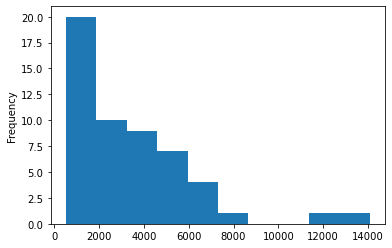

In [651]:
test_dataset.groupby("title").pair.count().plot.hist()

In [652]:
#titles2keep = [title for title, count in test_dataset.groupby("title").count().sort_values(by="epoch")["epoch"].to_dict().items() if count >= 2000]
#titles2remove = ['Ruhe ist die erste Bürgerpflicht', 'Soll und Haben', 'Die Ahnen', 'Witiko']

In [653]:
#test_dataset = test_dataset.query("title in @titles2keep and title not in @titles2remove ")

In [654]:
#meta_df = []
#for title, title_df in dict(tuple(test_dataset.groupby("title"))).items():
#    author = title_df.iloc[0].author
#    epoch = title_df.iloc[0].epoch
#    n_sents = len(title_df.query("labels == 0"))
#    meta_df.append({"author": author, "title": title, "epoch": epoch, "n_sents": n_sents})
#meta_df = pd.DataFrame.from_records(meta_df)
#titles2keep = meta_df.query("n_sents >= 500 and n_sents <= 7_000").title.to_list()
#print(len(titles2keep))
#print(meta_df.query("n_sents >= 500 and n_sents <= 7_000").groupby("epoch").title.count())
#test_dataset = test_dataset.query("title in @titles2keep")

In [655]:
#title_epoch_df = test_dataset[["title", "epoch"]].drop_duplicates()
#realismus2keep = title_epoch_df.query("epoch == 'realismus'").sample(len(title_epoch_df.query("epoch == 'romantik'")), random_state=63).title.to_list()
##assert "Effi Briest" in realismus2keep
#romantik2keep = title_epoch_df.query("epoch == 'romantik'").title.to_list()
#test_dataset = test_dataset.query("title in @realismus2keep or title in @romantik2keep")

<AxesSubplot:ylabel='Frequency'>

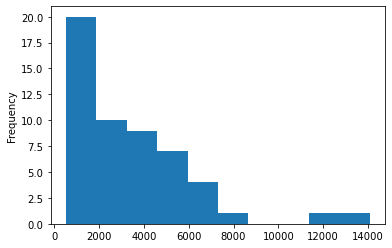

In [656]:
test_dataset.groupby("title").pair.count().plot.hist()

In [657]:
corpus

,author,title,epoch,text,pub_year_estim
0,"Alexis,-Willibald",Die Hosen des Herrn von Bredow,realismus,1. Kapitel. Die Herbstwäsche\n \n \n \n \n \n ...,1846.0
1,"Alexis,-Willibald",Ruhe ist die erste Bürgerpflicht,realismus,1. Kapitel. Die Kindesmörderin\n \n \n \n \n \...,1852.0
2,"Arnim,-Bettina-von",Goethes Briefwechsel mit einem Kinde,romantik,Erster Teil\n \n \n \n \n \n \n \n Vorrede\n \...,1835.0
3,"Arnim,-Bettina-von",Die Günderode,romantik,Den Studenten\n \n \n \n \n \n \n \nDen Studen...,1840.0
4,"Arnim,-Bettina-von",Clemens Brentanos Frühlingskranz,romantik,Bettina von Arnim\n\n\n Clemens Brentanos\n Fr...,1844.0
...,...,...,...,...,...
178,"Tieck,-Ludwig",Der junge Tischlermeister,romantik,Erster Teil\n \n \n \n \n \n \n \n Vorwort\n \...,1836.0
179,"Tieck,-Ludwig",Vittoria Accorombona,romantik,Erster Teil\n \n \n \n \n \n \n \n Vorwort\n \...,1840.0
180,"Waiblinger,-Wilhelm",Die Briten in Rom,romantik,Wilhelm Waiblinger\n\n\n Die Briten in Rom\n\n...,1828.0
181,"Waiblinger,-Wilhelm",Das Märchen von der blauen Grotte,romantik,Wilhelm Waiblinger\n\n\n Das Märchen von der b...,1828.0


In [658]:
g_df_total = (test_dataset.groupby(["epoch", "title", "author"]).match.sum() / test_dataset.groupby(["epoch", "title"]).match.count()).to_frame().reset_index().rename({"match": "Accuracy"}, axis=1)
g_df_total["n_sents"] = [len(test_dataset.query("title == @title").drop_duplicates("sent1_idx")) for title in g_df_total.title]
g_df_total["pub_year_estim"] = [corpus.query("title == @title").iloc[0]["pub_year_estim"] for title in g_df_total.title]
g_df_total.sort_values("Accuracy", ascending=False).head(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim
29,romantik,Das Leben der Hochgräfin Gritta von Rattenzuha...,"Arnim,-Bettina-von",0.942664,2808,1846.0
40,romantik,Franz Sternbalds Wanderungen,"Tieck,-Ludwig",0.942126,4337,1798.0
22,realismus,Ledwina,"Droste-Huelshoff,-Annette-von",0.940476,840,1822.0
44,romantik,Godwi oder Das steinerne Bild der Mutter,"Brentano,-Clemens",0.927869,5185,1801.0
10,realismus,Die Poggenpuhls,"Fontane,-Theodor",0.924556,2028,1895.0
45,romantik,Goethes Briefwechsel mit einem Kinde,"Arnim,-Bettina-von",0.922193,5655,1835.0
39,romantik,Die drei liebreichen Schwestern und der glückl...,"Arnim,-Ludwig-Achim-von",0.919721,573,1806.0
37,romantik,Die Nachtwachen des Bonaventura,"Klingemann,-August",0.905082,1338,1804.0
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",0.904553,1142,1825.0
17,realismus,Gustav Adolfs Page,"Meyer,-Conrad-Ferdinand",0.892460,809,1861.0


In [659]:
g_df_total.sort_values("Accuracy", ascending=False).tail(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim
42,romantik,Geschichte des Herrn William Lovell,"Tieck,-Ludwig",0.784746,7080,1795.0
24,realismus,Uli der Pächter,"Gotthelf,-Jeremias",0.782329,6055,1849.0
8,realismus,Die Hosen des Herrn von Bredow,"Alexis,-Willibald",0.781750,7441,1846.0
2,realismus,Bozena,"Ebner-Eschenbach,-Marie-von",0.767916,3977,1876.0
34,romantik,Die Briten in Rom,"Waiblinger,-Wilhelm",0.766217,2297,1828.0
18,realismus,Im alten Eisen,"Raabe,-Wilhelm",0.763552,2601,1887.0
52,romantik,Reiseschatten. Von dem Schattenspieler Luchs,"Kerner,-Justinus",0.760429,2613,1809.0
6,realismus,Der Schuß von der Kanzel,"Meyer,-Conrad-Ferdinand",0.750754,995,1861.0
4,realismus,Der Heilige,"Meyer,-Conrad-Ferdinand",0.723881,2144,1880.0
23,realismus,Stopfkuchen. Eine See- und Mordgeschichte,"Raabe,-Wilhelm",0.720064,3140,1891.0


<AxesSubplot:xlabel='epoch', ylabel='Accuracy'>

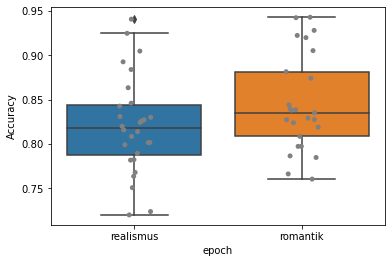

In [660]:
fig, ax = plt.subplots()
sns.boxplot(x="epoch", y="Accuracy", ax=ax, data=g_df_total)
sns.stripplot(x="epoch", y="Accuracy", color="gray", ax=ax, data=g_df_total)

#max_rom = g_df_total.query("epoch == 'romantik'").sort_values(by="Accuracy").iloc[-1]
#ax.annotate(f"{max_rom.title}",
#            xy=(1, max_rom.Accuracy), xycoords='data',
#            xytext=(1.5, .5), textcoords='axes fraction',
#            horizontalalignment="center",
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),
#            bbox=dict(boxstyle="round", fc="w"),
#            )
#min_rom = g_df_total.query("epoch == 'romantik'").sort_values(by="Accuracy").iloc[0]
#ax.annotate(f"{min_rom.title}",
#            xy=(1, min_rom.Accuracy), xycoords='data',
#            xytext=(1.5, 0), textcoords='axes fraction',
#            horizontalalignment="center",
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),
#            bbox=dict(boxstyle="round", fc="w"),
#            )
#
#
#max_rea = g_df_total.query("epoch == 'realismus'").sort_values(by="Accuracy").iloc[-1]
#ax.annotate(f"{max_rea.title}",
#            xy=(0, max_rea.Accuracy), xycoords='data',
#            xytext=(-0.5, .5), textcoords='axes fraction',
#            horizontalalignment="center",
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),
#            bbox=dict(boxstyle="round", fc="w"),
#            )
#min_rea = g_df_total.query("epoch == 'realismus'").sort_values(by="Accuracy").iloc[0]
#ax.annotate(f"{min_rea.title}",
#            xy=(0, min_rea.Accuracy), xycoords='data',
#            xytext=(-1, 0), textcoords='axes fraction',
#            horizontalalignment="center",
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),
#            bbox=dict(boxstyle="round", fc="w"),
#            )

<AxesSubplot:xlabel='Accuracy', ylabel='Density'>

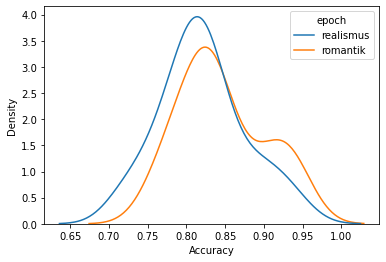

In [661]:
sns.kdeplot(x="Accuracy", hue="epoch", data=g_df_total)

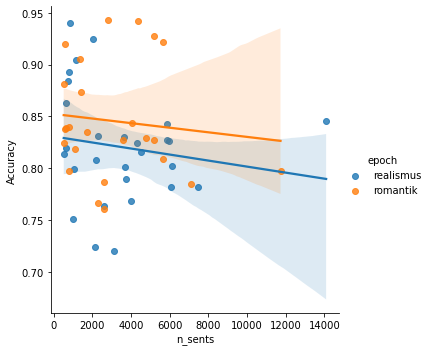

In [662]:
sns.lmplot(x="n_sents", y="Accuracy", hue="epoch", data=g_df_total)

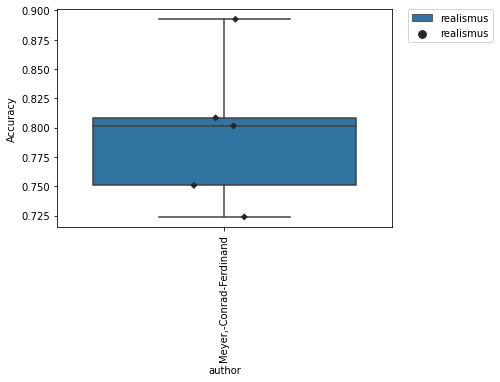

In [663]:
author_with_multiple_tiles = g_df_total.groupby("author").title.count().to_frame().query("title >= 5").index.to_list()
ax = sns.boxplot(hue="epoch", y="Accuracy", x="author", data=g_df_total.query("author in @author_with_multiple_tiles"))
sns.stripplot(hue="epoch", y="Accuracy", x="author", ax=ax, color="gray", marker="D", data=g_df_total.query("author in @author_with_multiple_tiles"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [664]:
#g_df_true = (test_dataset.query("labels == 0").groupby(["epoch", "title", "author"]).match.sum() / test_dataset.query("labels == 0").groupby(["epoch", "title"]).match.count()).to_frame().reset_index().rename({"match": "Accuracy"}, axis=1)

In [665]:
#sns.boxplot(x="epoch", y="Accuracy", data=g_df_true)
#sns.stripplot(x="epoch", y="Accuracy", color="gray", data=g_df_true)

In [666]:
#g_df_false = (test_dataset.query("labels == 1").groupby(["epoch", "title", "author"]).match.sum() / test_dataset.query("labels == 1").groupby(["epoch", "title"]).match.count()).to_frame().reset_index().rename({"match": "Accuracy"}, axis=1)

In [667]:
#sns.boxplot(x="epoch", y="Accuracy", data=g_df_false)
#sns.stripplot(x="epoch", y="Accuracy", color="gray", data=g_df_false)

In [668]:
matches = []
for title in test_dataset.title.unique():
    title_df = test_dataset.query("title == @title")
    #title_df = title_df.groupby("sent1_idx").aggregate({
    #    'author': lambda x: x.iloc[0],
    #    'title': lambda x: x.iloc[0],
    #    "epoch": lambda x: x.iloc[0],
    #    "pair": lambda x: x.iloc[0],
    #    "sent2_idx": lambda x: x.iloc[1],
    #    "match": "mean"
    #})
    title_df = test_dataset.query("title == @title and labels == 0")
    title_df = title_df.sort_values(by="sent1_idx")
    match = title_df["match"].to_list()
    matches.append(match)

In [669]:
matches = np.array([
    entry + [-1] * (max([len(i) for i in matches]) - len(entry))
    for entry in matches
])
matches = pd.DataFrame(matches, index=test_dataset.title.unique())
matches

,0,1,2,3,4,5,6,7,8,9,...,14084,14085,14086,14087,14088,14089,14090,14091,14092,14093
Die Hosen des Herrn von Bredow,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Das Leben der Hochgräfin Gritta von Rattenzuhausbeiuns,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Clemens Brentanos Frühlingskranz,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Die Günderode,1,1,1,1,1,0,1,0,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Goethes Briefwechsel mit einem Kinde,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Isabella von Ägypten,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Die drei liebreichen Schwestern und der glückliche Färber,1,1,1,0,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Geschichte vom braven Kasperl und dem schönen Annerl,0,0,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Godwi oder Das steinerne Bild der Mutter,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Ledwina,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


<AxesSubplot:>

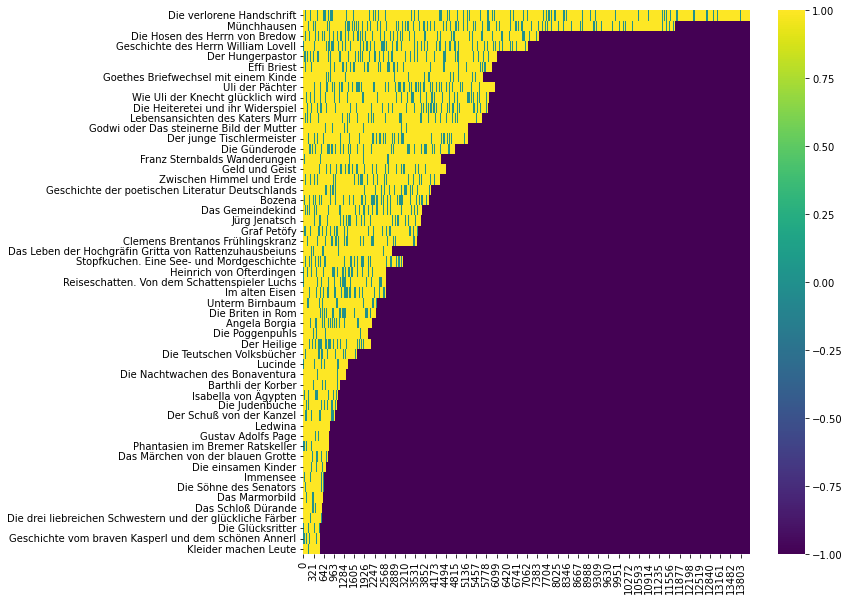

In [670]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matches.iloc[matches.sum(axis=1).argsort()[::-1]], ax=ax, cmap="viridis")

In [671]:
#import matplotlib.pyplot as plt
#
#for int_idx, (index, row) in enumerate(matches.iterrows()):
#    title = matches.index[int_idx]
#    epoch = test_dataset.query("title == @title").epoch.iloc[0]
#    fig, ax = plt.subplots(figsize=(10,1))
#    s = matches.loc[index].to_numpy()
#    s = s[s != -1].reshape(1, -1)
#    sns.heatmap(s, ax=ax, cmap="viridis", cbar=False)
#    #ax.set_title(title + " | " + epoch)
#    plt.title(title + " | " + epoch)
#    fig.savefig(f"test_pics/{epoch}_{title}.png")
#    plt.close(fig)
#

In [672]:
from more_itertools import divide
def fixed_window_mean(mat, window_size=100, padding_value=-1):
    means = []
    for x in mat:
        x = x[x != padding_value]
        x = list(x)
        means.append([np.mean(list(w)) for w in divide(window_size, x)])
    means = np.array(means)
    return means

In [787]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from tslearn.svm import TimeSeriesSVC
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

epochs = [test_dataset.query("title == @title").iloc[0].epoch for title in test_dataset.title.unique()]
le = LabelEncoder()
y = le.fit_transform(epochs)
window_size_calibration_score_dfs = []
for ws in tqdm(list(range(5, 100, 5))):
    
    fixed_window_means = fixed_window_mean(matches.to_numpy(), window_size=ws)
    epochs = [test_dataset.query("title == @title").iloc[0].epoch for title in test_dataset.title.unique()]
    fixed_window_means = pd.DataFrame(fixed_window_means, index=epochs)
    #fixed_window_means = pd.DataFrame(data=zscore(fixed_window_means, axis=0), index=fixed_window_means.index)
    
    cv_scores = pd.DataFrame(cross_validate(
        estimator=KNeighborsTimeSeriesClassifier(n_neighbors=7),
        X=fixed_window_means,
        y=y,
        scoring=["f1", "f1_macro", "f1_micro", "accuracy"],
        cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=3, random_state=42),
        n_jobs=12
    ))
    cv_scores["ws"] = ws
    window_size_calibration_score_dfs.append(cv_scores)
window_size_calibration_score_df = pd.concat(window_size_calibration_score_dfs)

  0%|          | 0/19 [00:00<?, ?it/s]

In [788]:
window_size_calibration_score_df.groupby("ws").mean()

,fit_time,score_time,test_f1,test_f1_macro,test_f1_micro,test_accuracy
ws,,,,,,
5,0.003442,0.054310,0.419701,0.497812,0.518954,0.518954
10,0.003567,0.055391,0.490931,0.553325,0.570675,0.570675
15,0.003642,0.056459,0.413933,0.528105,0.562026,0.562026
20,0.003596,0.057470,0.367062,0.489486,0.525817,0.525817
25,0.003671,0.058827,0.400843,0.516686,0.550643,0.550643
30,0.003728,0.060339,0.424122,0.529670,0.559564,0.559564
35,0.003734,0.062275,0.361263,0.502886,0.549227,0.549227
40,0.003761,0.064484,0.368746,0.506671,0.551656,0.551656
45,0.003823,0.066601,0.251808,0.438412,0.505251,0.505251


<AxesSubplot:xlabel='ws', ylabel='test_f1'>

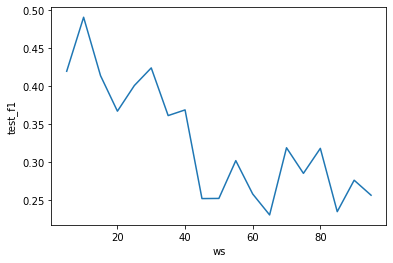

In [789]:
sns.lineplot(x="ws", y="test_f1", data=window_size_calibration_score_df.groupby("ws").mean())

In [790]:
fixed_window_means = fixed_window_mean(matches.to_numpy(), window_size=10)
fixed_window_means.shape

(53, 10)

In [791]:
epochs = [test_dataset.query("title == @title").iloc[0].epoch for title in test_dataset.title.unique()]
fixed_window_means = pd.DataFrame(fixed_window_means, index=epochs)

In [792]:
def normalize_df(df):
    return (df-df.mean())/df.std()

In [793]:
#fixed_window_means = normalize_df(fixed_window_means)

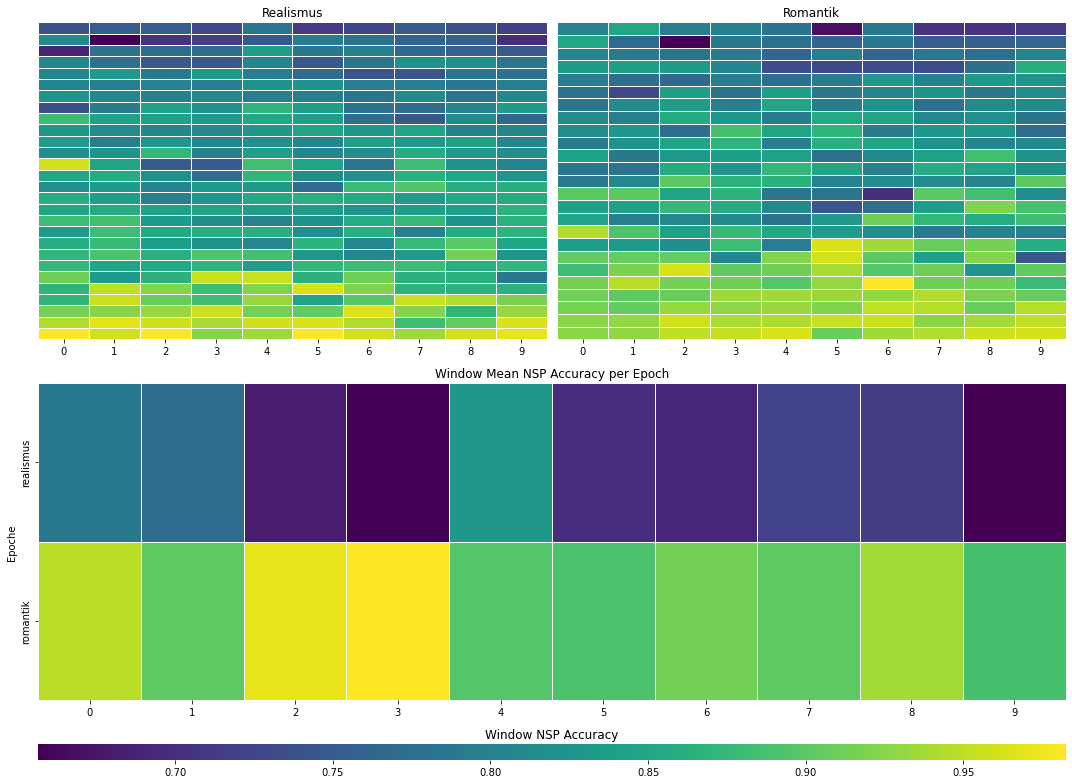

In [794]:
fig = plt.figure(figsize=(15, 11))
#gs = fig.add_gridspec(5,2, height_ratios=[2, 2, 0.1, 2, 0.1])
gs = fig.add_gridspec(3,2, height_ratios=[2, 2, 0.1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
#ax5 = fig.add_subplot(gs[3, :])
#ax6 = fig.add_subplot(gs[4, :])

fixed_window_means_rea = fixed_window_means.iloc[fixed_window_means.index == "realismus"]
fixed_window_means_rea = fixed_window_means_rea.iloc[fixed_window_means_rea.mean(axis=1).argsort()]
ax1.set_title("Realismus")
sns.heatmap(fixed_window_means_rea, cmap="viridis", ax=ax1, cbar=False, yticklabels=False, linewidths=.5)

fixed_window_means_rom = fixed_window_means.iloc[fixed_window_means.index == "romantik"]
fixed_window_means_rom = fixed_window_means_rom.iloc[fixed_window_means_rom.mean(axis=1).argsort()]

ax2.set_title("Romantik")
ax4.set_title("Window NSP Accuracy")
sns.heatmap(fixed_window_means_rom, cmap="viridis", ax=ax2, cbar=True, yticklabels=False, cbar_ax=ax4, cbar_kws={"orientation": "horizontal"}, linewidths=.5)

ax3.set_title("Window Mean NSP Accuracy per Epoch")
fixed_window_means_epoch = fixed_window_means.reset_index().rename({"index": "Epoche"}, axis=1).groupby("Epoche").mean()
sns.heatmap(fixed_window_means_epoch, ax=ax3, cmap="viridis", cbar=False, linewidths=.5)

#ax5.set_title("Window STD per Epoch")
#fixed_window_std_epoch = fixed_window_means.reset_index().rename({"index": "Epoche"}, axis=1).groupby("Epoche").std()
#sns.heatmap(fixed_window_std_epoch, ax=ax5, cmap="magma", cbar=True, linewidths=.5, cbar_ax=ax6, cbar_kws={"orientation": "horizontal"})

fig.tight_layout()

<AxesSubplot:xlabel='Window Index', ylabel='Window Mean'>

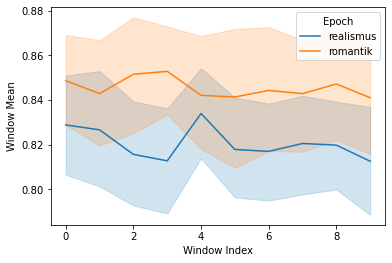

In [795]:
sns.lineplot(x="Window Index", y="Window Mean", hue="Epoch", data=fixed_window_means.reset_index().rename({"index": "Epoch"}, axis=1).melt(id_vars=["Epoch"], var_name="Window Index", value_name="Window Mean"))

In [796]:
def filter_singletons(matches: pd.DataFrame, window_size=2, window_sum=3, stride=None, padding_value=-1):
    if stride is None:
        stride = window_size
    # 1 = Correct, 0 = False
    data = matches.to_numpy().copy()
    filtered_data = []
    for entry in data:
        entry.copy()
        for idx in range(0, len(entry), stride):
            window_start = max(0, idx - window_size)
            window_end = min(idx + window_size, len(entry))
            window = entry[window_start:window_end]
            window = window[window != padding_value]
            if len(window) == 0:
                continue
            if window.sum() >= window_sum:
                entry[window_start:(window_end - len(window))] = 1

        filtered_data.append(entry)
    filtered_matches = pd.DataFrame(filtered_data, index=matches.index)
    return filtered_matches    

In [797]:
#matches_filtered = filter_singletons(matches, window_size=10, window_sum=19)
matches_filtered = matches
(matches_filtered.to_numpy() == matches.to_numpy()).all(), matches_filtered.shape, matches.shape

(True, (53, 14094), (53, 14094))

In [798]:
matches.to_numpy(), matches_filtered.to_numpy()

(array([[ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1]]),
 array([[ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1]]))

In [809]:
import matplotlib.pyplot as plt
plot_data_rom = []
plot_data_rea = []
for int_idx, (index, row) in enumerate(matches_filtered.iterrows()):
    title = matches_filtered.index[int_idx]
    epoch = test_dataset.query("title == @title").epoch.iloc[0]
    s = matches_filtered.loc[index].to_numpy()
    s = s[s != -1].reshape(1, -1)
    #s = pd.Series(s.ravel()).rolling(10).mean().dropna().to_numpy().reshape(1, -1)
    if epoch == "romantik":
        plot_data_rom.append({"title": title, "epoch": epoch, "s": s})
    else:
        plot_data_rea.append({"title": title, "epoch": epoch, "s": s})
plot_data_rom = list(sorted(plot_data_rom, key=lambda entry: entry["s"].mean()))
plot_data_rea = list(sorted(plot_data_rea, key=lambda entry: entry["s"].mean()))

plot_data =  plot_data_rea + plot_data_rom
np.mean([entry["s"].mean() for entry in plot_data])

0.8323217209768542

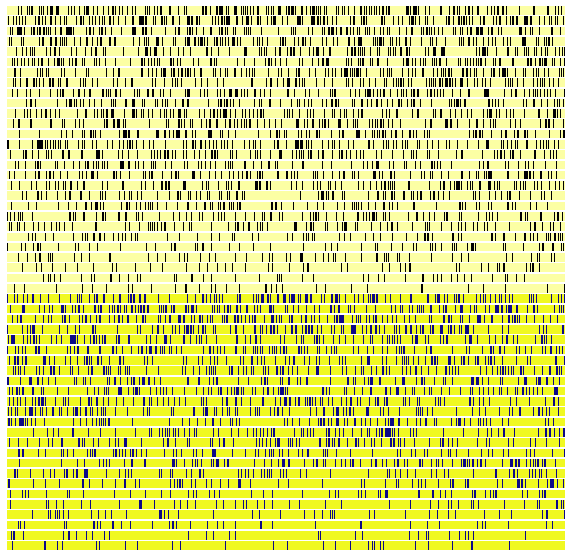

In [812]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(plot_data), 1, figsize=(10,10))
for int_idx, entry in enumerate(plot_data):
    ax = axs[int_idx]
    epoch = entry["epoch"]
    title = entry["title"]
    s = entry["s"]
    sns.heatmap(s, ax=ax, cmap="plasma" if epoch == "romantik" else "inferno", cbar=False, yticklabels=False, xticklabels=False)
    #ax.set_title(title + " | " + epoch)
plt.show()

In [801]:
title_dfs = {title: title_df.copy().reset_index(drop=True) for title, title_df in dict(tuple(test_dataset.groupby("title"))).items()}

In [837]:
def get_uncertainty_regions(title_df, expand_steps: int = 10, threshold=0.5):
    regions = []
    index = 0
    while index < len(title_df):
        if title_df.iloc[index]["match"] == 0:
            expand_window_start_index = index
            expand_window_end_index = min(index + expand_steps, len(title_df))
            expand_window = title_df.iloc[index: expand_window_end_index]
            if expand_window["match"].mean() <= threshold:
                while expand_window["match"].mean() < 0.5:
                    curr_windows_start_index = expand_window_end_index
                    expand_window_end_index = expand_window_end_index + expand_steps
                    if expand_window_end_index > len(title_df):
                        break
                    expand_window = title_df.iloc[expand_window_start_index: expand_window_end_index]
                final_window = title_df.iloc[expand_window_start_index: expand_window_end_index]
                regions.append(final_window)
                index = expand_window_end_index
        index += 1
    return regions

In [889]:
def get_uncertainty_regions(title_df, threshold=5):
    regions = []
    index = 0
    while index < len(title_df):
        if title_df.iloc[index]["match"] == 0:
            expand_window_start_index = index
            while index < len(title_df) and title_df.iloc[index]["match"] == 0:
                index += 1
            expand_window_end_index = index
            region_df = title_df.iloc[expand_window_start_index:expand_window_end_index]
            if len(region_df) >= max(threshold, 2):
                regions.append(region_df)
        else:
            index += 1
    return regions

In [914]:
uncertainty_regions = {}
for title, title_df in tqdm(title_dfs.items()):
    uncertainty_regions[title] = get_uncertainty_regions(title_df.copy(), threshold=2)

  0%|          | 0/53 [00:00<?, ?it/s]

In [915]:
g_df_total_merged = g_df_total.merge(pd.Series({title: len(regions) for title, regions in uncertainty_regions.items()}, name="N_Uncertainty_Regions"), left_on="title", right_index=True)
g_df_total_merged = g_df_total_merged.merge(pd.Series({title: np.mean([len(region) for region in regions]) for title, regions in uncertainty_regions.items()}, name="Uncertainty_Regions_Mean_Length"), left_on="title", right_index=True)
g_df_total_merged

,epoch,title,author,Accuracy,n_sents,pub_year_estim,N_Uncertainty_Regions,Uncertainty_Regions_Mean_Length
0,realismus,Angela Borgia,"Meyer,-Conrad-Ferdinand",0.808383,2171,1891.0,74,2.445946
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",0.904553,1142,1825.0,12,2.083333
2,realismus,Bozena,"Ebner-Eschenbach,-Marie-von",0.767916,3977,1876.0,192,2.348958
3,realismus,Das Gemeindekind,"Ebner-Eschenbach,-Marie-von",0.789544,3730,1887.0,152,2.342105
4,realismus,Der Heilige,"Meyer,-Conrad-Ferdinand",0.723881,2144,1880.0,117,2.555556
5,realismus,Der Hungerpastor,"Raabe,-Wilhelm",0.801699,6122,1863.0,217,2.341014
6,realismus,Der Schuß von der Kanzel,"Meyer,-Conrad-Ferdinand",0.750754,995,1861.0,52,2.230769
7,realismus,Die Heiteretei und ihr Widerspiel,"Ludwig,-Otto",0.827137,5837,1857.0,177,2.288136
8,realismus,Die Hosen des Herrn von Bredow,"Alexis,-Willibald",0.781750,7441,1846.0,335,2.364179
9,realismus,Die Judenbuche,"Droste-Huelshoff,-Annette-von",0.799061,1065,1839.0,42,2.309524


<AxesSubplot:xlabel='epoch', ylabel='Rel_Uncertainty_Regions'>

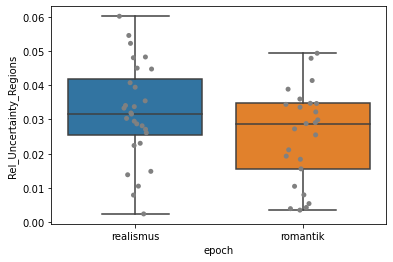

In [918]:
g_df_total_merged["Rel_Uncertainty_Regions"] = g_df_total_merged["N_Uncertainty_Regions"] / g_df_total_merged["n_sents"]
sns.boxplot(x="epoch", y="Rel_Uncertainty_Regions", data=g_df_total_merged)
sns.stripplot(x="epoch", y="Rel_Uncertainty_Regions", color="gray", data=g_df_total_merged)

<AxesSubplot:xlabel='epoch', ylabel='Uncertainty_Regions_Mean_Length'>

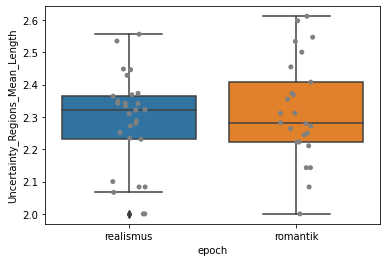

In [919]:
sns.boxplot(x="epoch", y="Uncertainty_Regions_Mean_Length", data=g_df_total_merged)
sns.stripplot(x="epoch", y="Uncertainty_Regions_Mean_Length", color="gray", data=g_df_total_merged)

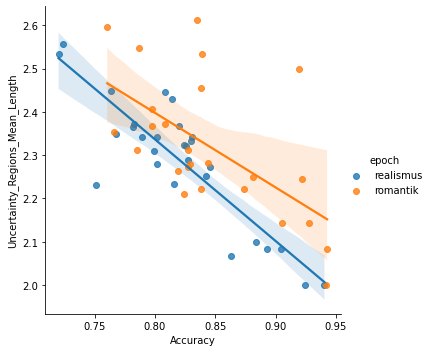

In [922]:
sns.lmplot(x="Accuracy", y="Uncertainty_Regions_Mean_Length", hue="epoch", data=g_df_total_merged)

In [895]:
def convert_uncertainty_regions(uncertainty_regions):
    data = []
    for title, regions in uncertainty_regions.items():
        for region in regions:
            start_index = region.sent1_idx.min()
            end_index = region.sent1_idx.max()
            text = " ".join(region.sent1) + " " + region.iloc[-1].sent2
            title = region.iloc[0].title
            author = region.iloc[0].author
            epoch = region.iloc[0].epoch
            data.append({
                "author": author,
                "title": title,
                "epoch": epoch,
                "text": text,
                "start_index": start_index,
                "end_index": end_index,
                "n_sents": end_index - start_index + 1
            })
    return pd.DataFrame.from_records(data)

In [896]:
unc_df = convert_uncertainty_regions(uncertainty_regions)

<AxesSubplot:xlabel='n_sents', ylabel='Count'>

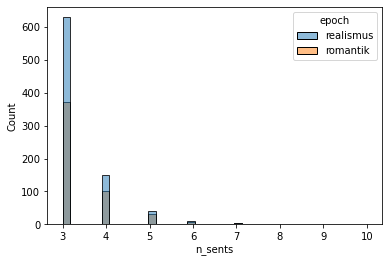

In [907]:
sns.histplot(x="n_sents", hue="epoch", data=unc_df)

In [898]:
unc_df

,author,title,epoch,text,start_index,end_index,n_sents
0,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,Ich halte es mit dem Gaukler und preise ihre K...,41,43,3
1,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,Und noch einmal erscholl die Stimme des Mädche...,161,163,3
2,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,Mitten in dieser erhitzten Szene betrat ein Pa...,294,296,3
3,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,"Strozzi sah den grotesken Kampf und lachte: ""S...",377,380,4
4,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,Rette das Mädchen! Damit wollte ich dich betra...,410,413,4
...,...,...,...,...,...,...,...
1350,"Ludwig,-Otto",Zwischen Himmel und Erde,realismus,"Wenn er gehen müßte, er! die Kinder hingen sic...",3403,3405,3
1351,"Ludwig,-Otto",Zwischen Himmel und Erde,realismus,Hier und da dehnte sich der feste Umriß der du...,3867,3869,3
1352,"Ludwig,-Otto",Zwischen Himmel und Erde,realismus,"Auf dem ganzen Wege nach Sankt Georg, unter de...",3953,3956,4
1353,"Ludwig,-Otto",Zwischen Himmel und Erde,realismus,"Nur der Gesell, den er am Ofen beschäftigt fan...",4010,4012,3


In [903]:
print(*unc_df.query("n_sents > 5").text.sample(10), sep="\n\n")

Was bleibt von dem Glücke des Menschen, wenn man die Hoffnung vor dem Kampf, vor dem Erlangen des Wunsches und diese ersten verwirrten, unklaren Augenblicke nach ihm davon abzieht? Summa cum laude! lächelte der Sonnenstrahl, der das Bett, in welchem Hans Unwirrsch mit halbgeschlossenen Augenlidern lag, umspielte! Summa cum laude! zwitscherten die frühwachen Sperlinge und Schwalben vor dem Fenster. Summa cum laude! riefen die Glocken, die den Grünen Donnerstag einläuteten. Summa cum laude! sagte Hans Unwirrsch, als er in der Mitte seiner Kammer stand und einen Bückling machte, welcher ihm selber galt.

Der alte Schwaning kam heraus. Er kannte sie nicht gleich, und fragte nach ihrem Namen und Anliegen. Heinrichs Mutter weinte, und fiel ihm um den Hals. Kennt Ihr Eure Tochter nicht mehr? rief sie weinend. Ich bringe euch meinen Sohn. Der alte Vater war äußerst gerührt. Er drückte sie lange an seine Brust; Heinrich sank auf ein Knie, und küßte ihm zärtlich die Hand.

Da diese letzte Frage,

In [908]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("nsp_classif/", device="cuda:1")

In [910]:
from scipy.spatial.distance import euclidean, minkowski, cosine

METRICS = {
    "euclidean": euclidean,
    "cosine": cosine,
    "manhattan": lambda x, y: minkowski(x, y, p=1)   
}

def compute_dists(uncertainty_region_df, verbose=False):
    if verbose:
        it = enumerate(tqdm(uncertainty_region_df.iterrows(), total=len(uncertainty_region_df), desc="Computing dists for pair each of sent."))
    else:
        it = enumerate(uncertainty_region_df.iterrows())
    for index, (df_index, row) in it:
        for metric_name, metric in METRICS.items():
            if index == 0:
                uncertainty_region_df.loc[df_index, metric_name] = 0.0
            else:
                embedding1, embedding2 = (model.encode(sent) for sent in (row["sent1"], row["sent2"]))
                uncertainty_region_df.loc[df_index, metric_name] = metric(embedding1, embedding2)
    return uncertainty_region_df

In [931]:
uncertainty_regions = {title: [compute_dists(entry, verbose=False) for entry in region_dfs] for title, region_dfs in tqdm(uncertainty_regions.items())}

  0%|          | 0/53 [00:00<?, ?it/s]

In [949]:
for title, region_dfs in uncertainty_regions.items():
    for region_index, region_df in enumerate(region_dfs):
        region_df["region_index"] = region_index

In [950]:
from more_itertools import flatten

unc_region_df = pd.concat(list(flatten([region_dfs for region_dfs in uncertainty_regions.values()])))
unc_region_df.head(3)

,author,title,epoch,pair,sent1_idx,sent2_idx,sent1,sent2,labels,pred,match,euclidean,cosine,manhattan,region_index
18,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,"Ihr Begehren, dessen Heftigkeit sie verbarg, e...",18,19,"Ihr Begehren, dessen Heftigkeit sie verbarg, e...","Beim Anblick dieser ruhigen, geschlossenen Mie...",0,1,0,0.000000,0.000000,0.000000,0
19,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,"Beim Anblick dieser ruhigen, geschlossenen Mie...",19,20,"Beim Anblick dieser ruhigen, geschlossenen Mie...",Mit diesem bin ich gerettet.,0,1,0,16.877283,0.585029,226.651001,0
23,"Meyer,-Conrad-Ferdinand",Angela Borgia,realismus,"Und er wird meine Gaben kennenlernen, meine Re...",23,24,"Und er wird meine Gaben kennenlernen, meine Re...",Niemals werde ich ihm den Schatten eines Anlas...,0,1,0,0.000000,0.000000,0.000000,1


In [958]:
unc_region_df.groupby(["epoch", "title", "region_index"]).cosine.mean().reset_index()

<AxesSubplot:xlabel='epoch', ylabel='cosine'>

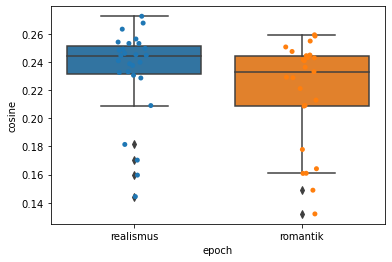

In [957]:
sns.boxplot(x="epoch", y="cosine", data=unc_region_df.groupby(["epoch", "title"]).cosine.mean().reset_index().query("cosine > 0.1"))
sns.stripplot(x="epoch", y="cosine", data=unc_region_df.groupby(["epoch", "title"]).cosine.mean().reset_index().query("cosine > 0.1"))

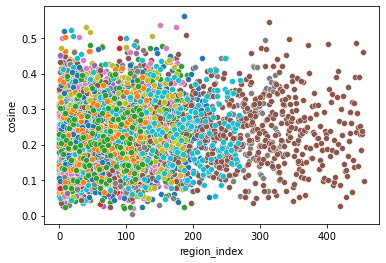

In [966]:
fig, ax = plt.subplots()
for title in unc_region_df.title.unique():
    title_df = unc_region_df.groupby(["epoch", "title", "region_index"]).cosine.mean().reset_index().query("title == @title")
    sns.scatterplot(x="region_index", y="cosine", data=title_df, ax=ax)

In [1044]:
sys.getsizeof(gzip.compress(("0"*1000).encode()))

62

In [1045]:
sys.getsizeof(gzip.compress(("01"*500).encode()))

63

In [1046]:
sys.getsizeof(gzip.compress(("1"*1000).encode()))

62